# Steps to Tackle a Time Series Problem (with Codes in Python)
Note: codes adapted / summarzed from [article](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/).

This notebook includes additional code in order to forecast out of sample periods

## Loading and Handling TS in Pandas

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [120]:
#Note: aim is not to teach stock price forecasting. It's a very complex domain and I have almost no clue about it. Here I will demonstrate the various techniques which can be used for time-series forecasting
data = pd.read_csv('../data/AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


Reading as datetime format:

In [121]:
data = pd.read_csv('../data/AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'],format='%Y-%m')
data.set_index('Month', inplace=True)
data.info()
data['#Passengers']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
1950-01-01    115
1950-02-01    126
1950-03-01    141
1950-04-01    135
1950-05-01    125
1950-06-01    149
1950-07-01    170
1950-08-01    170
1950-09-01    158
1950-10-01    133
1950-11-01    114
1950-12-01    140
1951-01-01    145
1951-02-01    150
1951-03-01    178
1951-04-01    163
1951-05-01    172
1951-06-01    178
             ... 
1958-07-01    491
1958-08-01    505
1958-09-01    404
1958-10-01    359
1958-11-01    310
1958-12-01    337
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960

In [122]:
data.dtypes

#Passengers    int64
dtype: object

In [123]:
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [124]:
#convert to time series:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

# Checking for stationarity

## Plot the time-series

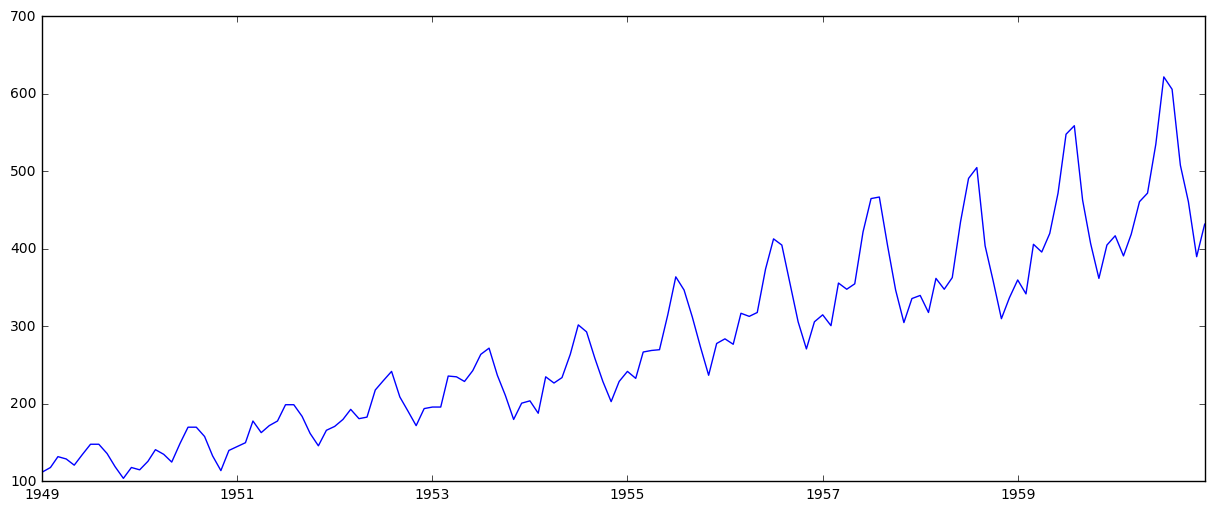

In [125]:
plt.plot(ts)

### Function for testing stationarity

In [126]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\ariel\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ariel\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


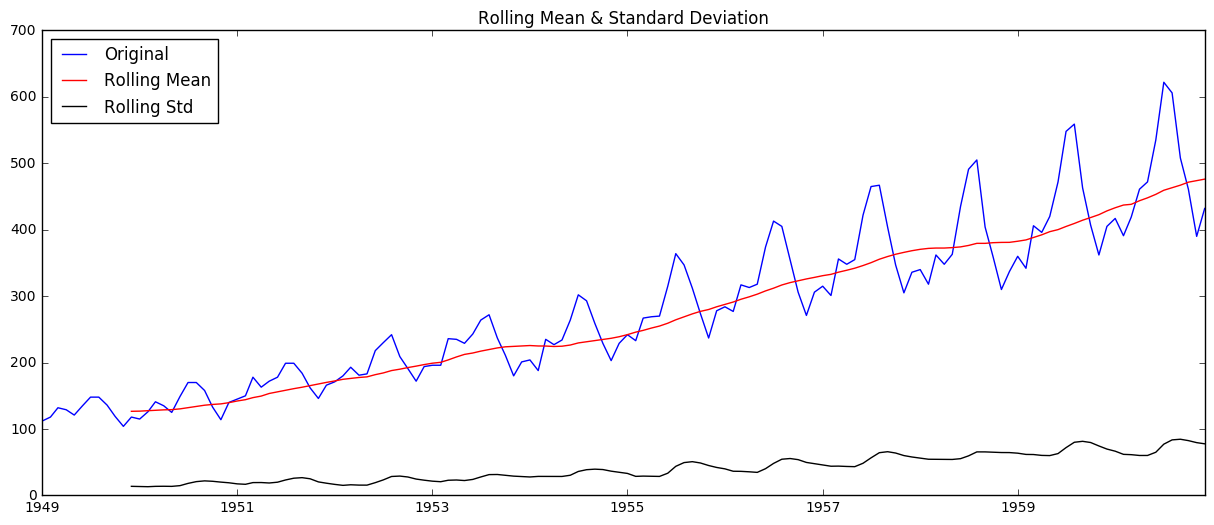

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (10%)            -2.578770
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
dtype: float64


In [127]:
test_stationarity(ts)

# Making TS Stationary


## Estimating & Eliminating Trend


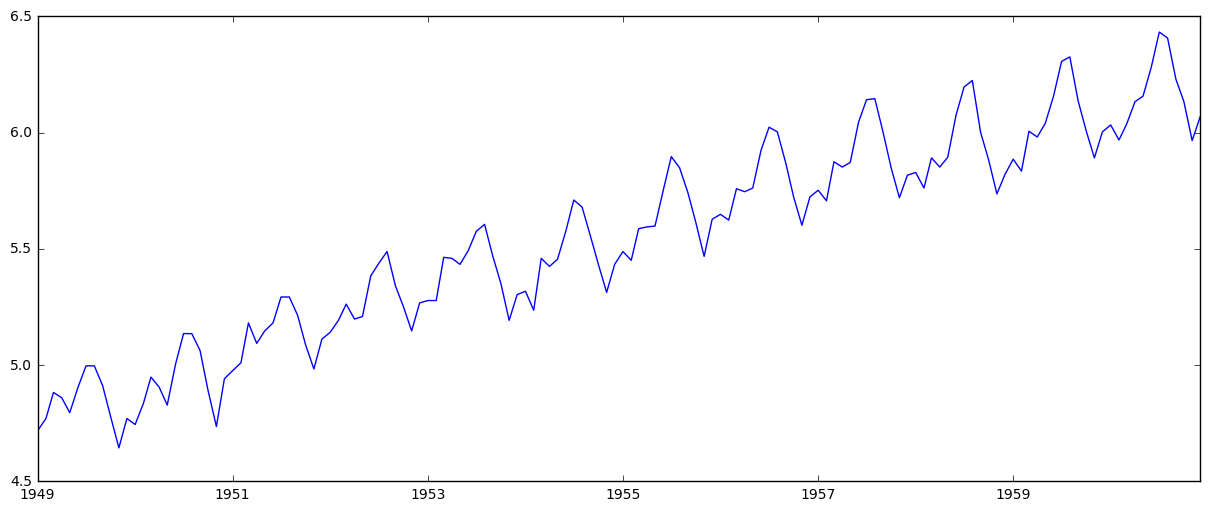

In [128]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Techinques to remove trend

Idea: To estimate or model the trend. The estimated trend will be used to remove it from the serie.

1. **Aggregation** – taking average for a time period like monthly/weekly averages
2. **Smoothing** – taking rolling averages
3. **Polynomial Fitting** – fit a regression model


## Smoothing techniques (2)

a. **Moving average**
```
# take the average over the past 1 year
moving_avg = pd.rolling_mean(ts_log,12)
# remove trend from the serie
ts_log_moving_avg_diff = ts_log - moving_avg
```
A drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number.


b. **Exponential weighted moving average**
```
expwighted_avg = pd.ewma(ts_log, halflife=12)
ts_log_ewma_diff = ts_log - expwighted_avg
```
We take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. Find details [here](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions).

## Eliminating Trend and Seasonality

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

1. **Differencing** – taking the difference with a particular time lag

  **One of the most common methods of dealing with both trend and seasonality is differencing**. In this technique, we take the 
difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:


2. **Decomposition** – modeling both trend and seasonality and removing them from the model.

  In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned (i.e., residuals).

  Converting the residuals into original values for future data in not very intuitive in this case.


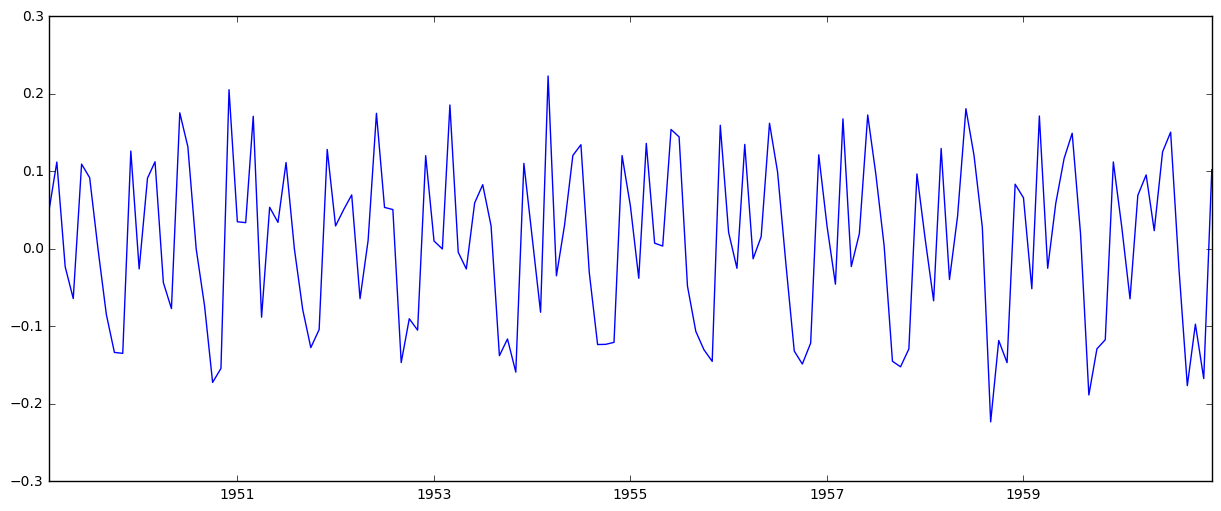

In [129]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift(1)
plt.plot(ts_log_diff)

C:\Users\ariel\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\ariel\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


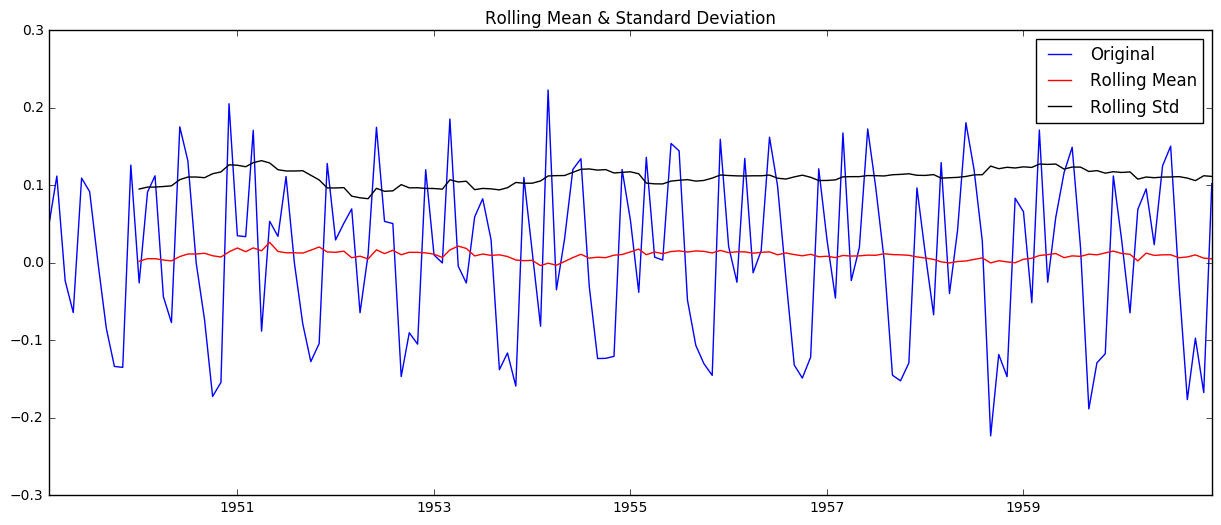

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (10%)            -2.578960
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
dtype: float64


In [130]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# Final Forecasting

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model.

In [131]:
from statsmodels.tsa.arima_model import ARIMA

### ACF & PACF Plots

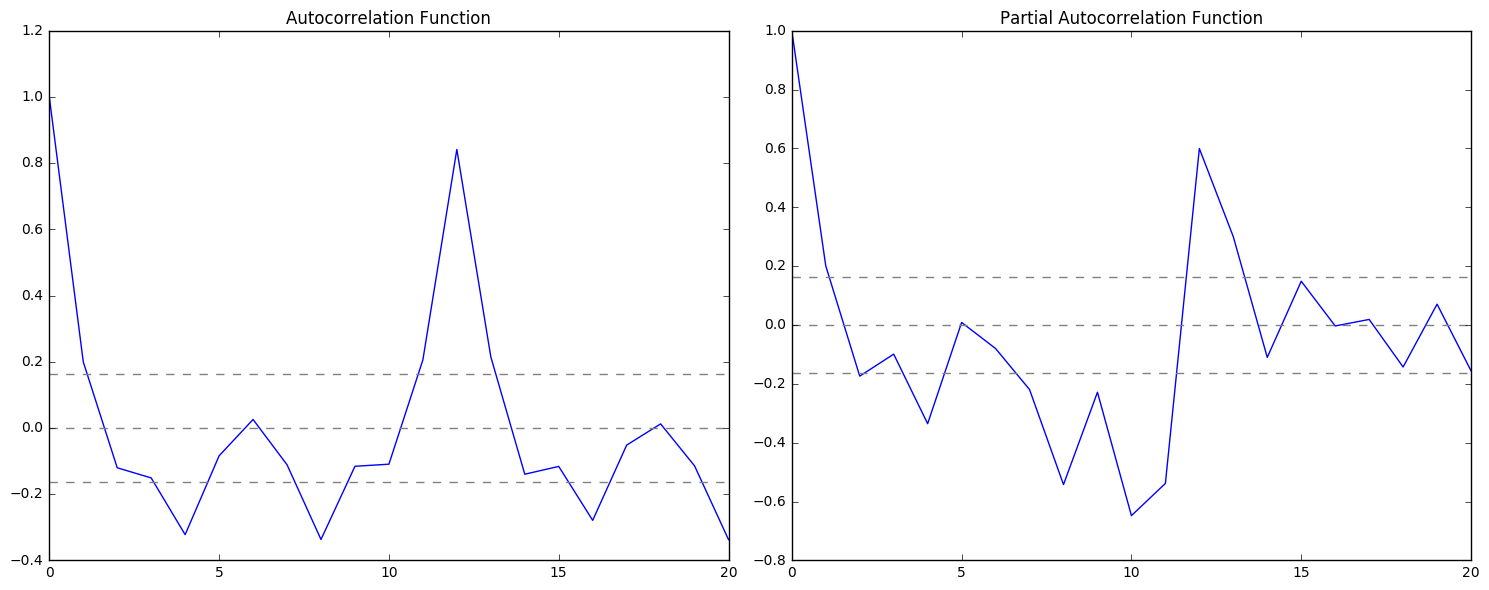

In [132]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

1. **p** – The lag value where the **PACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
2. **q** – The lag value where the **ACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

**Intuition: example stock price, the stock price at a given lag, should be estimated based on one previous lag? or the 2 previous lags? 3 previous lags?**

### Correlogram (ACF) of the in-sample forecast errors for lags 1-20

The light blue area is the 95% condifence band. Dots are the autocorrelation/partial autocorrelation values.

??? The autocorrelation at lag 2 is the first insde the the significance bound ???

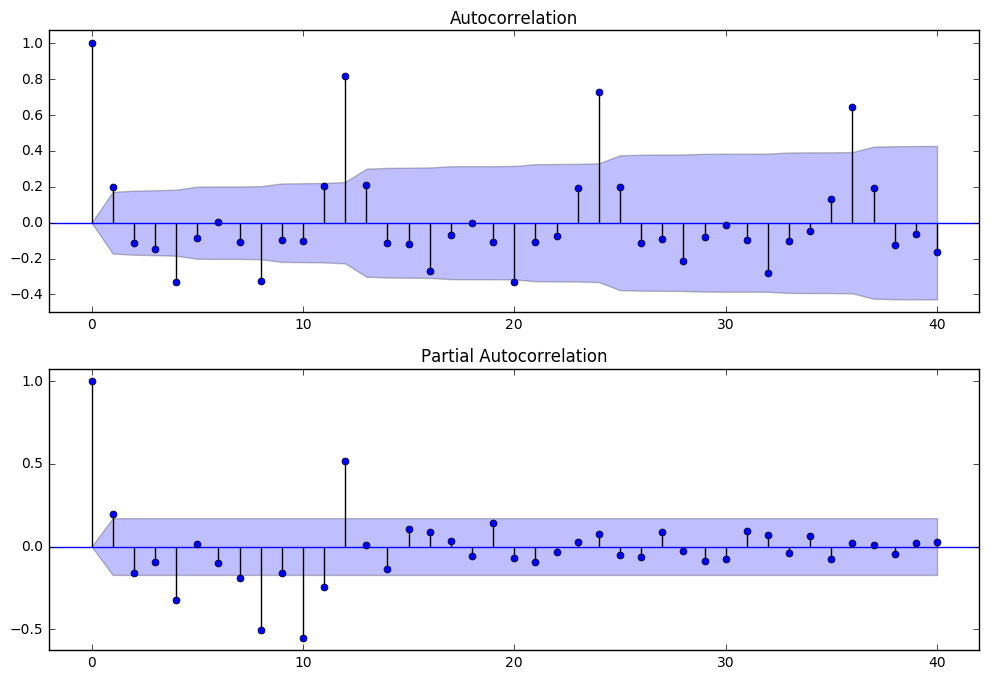

In [133]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.iloc[13:], lags=40, ax=ax2)

### Competing models: AR, MA, ARIMA

* **AR Model**

  **y** values depends only on its own **p** past values. Represented as **AR(p)**, Where **p** is the number of **past values**

  AR(p) equivalent to ARIMA(p,d,0)
  

* **MA Model**

  **y** values depends only on the random error terms which follows a white noise process. Represented as **MA(q)**, Where **q** is the number of **past values**

  MA(q) equivalent to ARIMA(0,d,q)
  

* **ARIMA Model**
  model = ARIMA(**TS**, order=(**p**, **d**, **q**))

  The 'd' param is the order of differencing that the ARIMA algorithm will apply on the timeseries data and this order can be 0 (no-differencing) or another number.
  Since we have a variable ts_log_diff with differencing of 1 already computed, therefore:

```
model = ARIMA(ts_log_diff, order=(2, 0, 2))
```
produce same result as:
```
model = ARIMA(ts_log, order=(2, 1, 2))
```

In [134]:
from statsmodels.tsa.arima_model import ARIMA

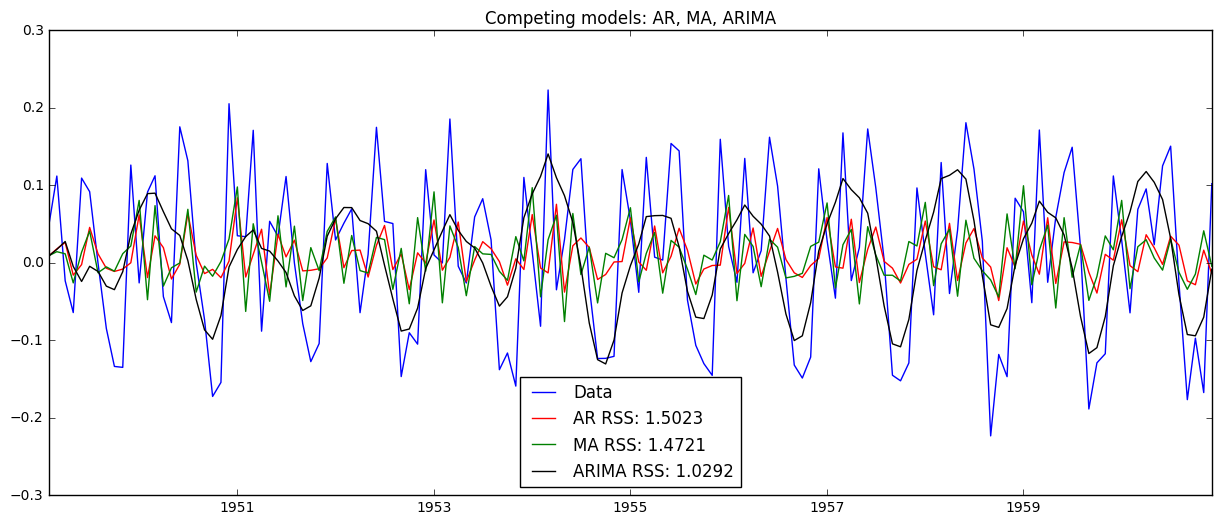

In [135]:
# AR model
model = ARIMA(ts_log, order=(2, 1, 0))
results_AR = model.fit(disp=-1)
# MA model
model = ARIMA(ts_log, order=(0, 1, 2))
results_MA = model.fit(disp=-1)
# ARIMA model
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)

orig = plt.plot(ts_log_diff, color='blue', label='Data')
ar_plt = plt.plot(results_AR.fittedvalues, color='red', label='AR RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
ma_plt = plt.plot(results_MA.fittedvalues, color='green', label='MA RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
arima_plt = plt.plot(results_ARIMA.fittedvalues, color='black', label='ARIMA RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.legend(loc='best')
plt.title('Competing models: AR, MA, ARIMA')

ARIMA beats AR and MA judging from RSS. What about AIC?

In [136]:
# Best AIC
AICs = {'AR':results_AR.aic, 'MA':results_MA.aic, 'ARIMA':results_ARIMA.aic}

print (min(AICs.items(), key=lambda x: x[1]))

('ARIMA', -287.28080792170346)


### Convert to original scale:

In [137]:
ts.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [138]:
results_ARIMA.fittedvalues.tail(5)

Month
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
dtype: float64

In [139]:
#def restore_trend_and_seasonality(ts, ts_predicted_differenciatted):
#    predictions_ARIMA_log = pd.Series(ts.ix[0], index=ts.index)
#    predictions_ARIMA_log = predictions_ARIMA_log.add(ts_predicted_differenciatted.cumsum(),fill_value=0)   
#    return predictions_ARIMA_log

def restore_trend_and_seasonality(starting_value, fit):
    fit_ARIMA_log = pd.Series(starting_value, index=fit.index[:])
    fit_ARIMA_log = fit_ARIMA_log.add(fit.cumsum(),fill_value=0)
    return fit_ARIMA_log

In [140]:
#predictions_ARIMA_log = restore_trend_and_seasonality(ts_log, results_ARIMA.fittedvalues)
predictions_ARIMA_log = restore_trend_and_seasonality(ts_log.ix[0], results_ARIMA.fittedvalues)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

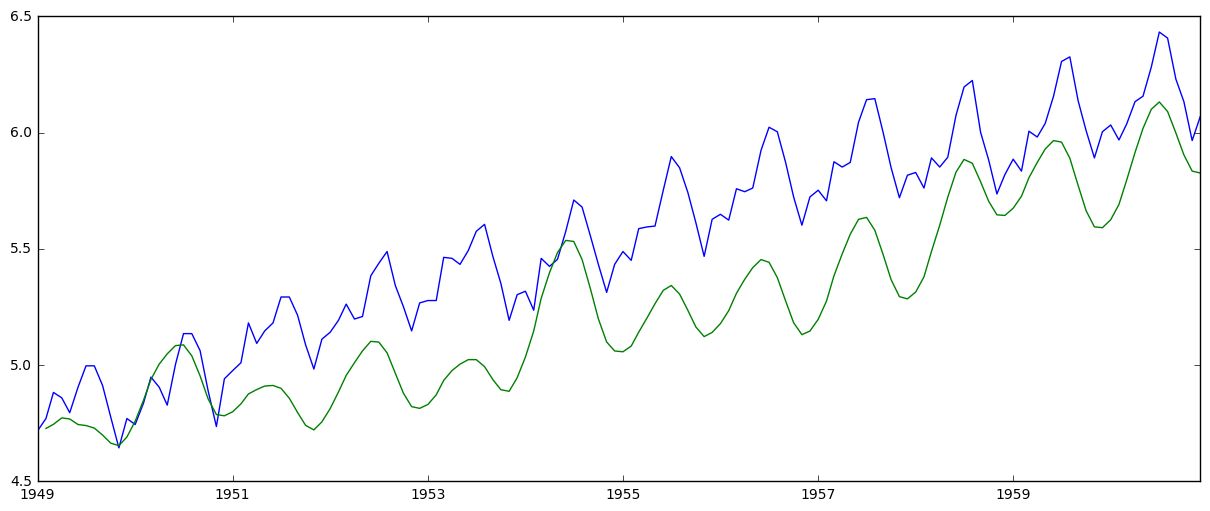

In [141]:
# plot (still in log scale)
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

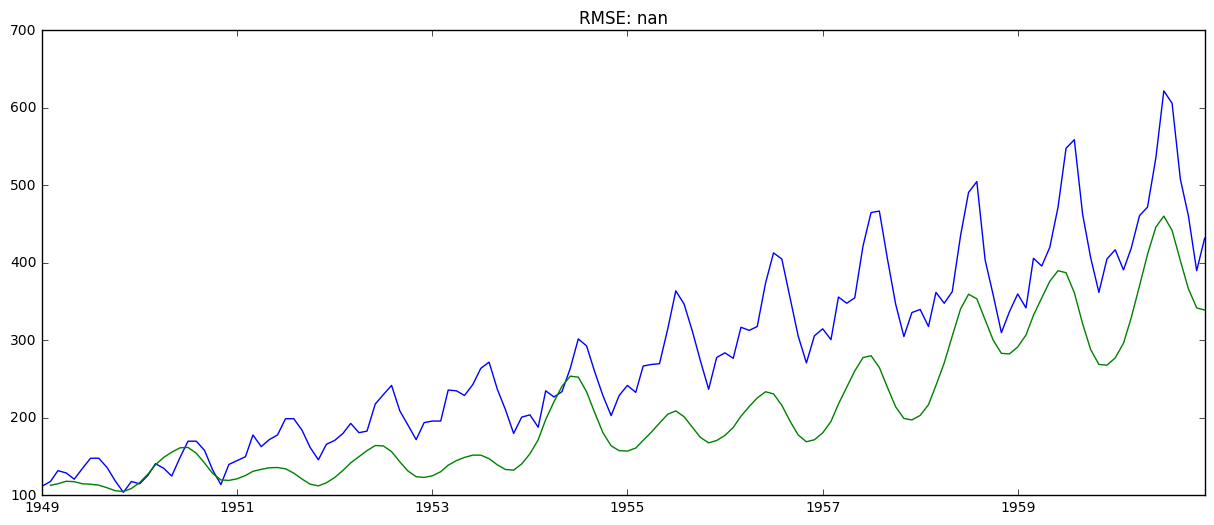

In [142]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

# Future forecasts

In order to generate future forecasts, use a dataframe wich will contains next 12 periods following the last period in sample

In [143]:
# last period:
ts_log.tail(1)

Month
1960-12-01    6.068426
Name: #Passengers, dtype: float64

In [144]:
from dateutil.relativedelta import relativedelta
import datetime

start = datetime.datetime.strptime("1961-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]

future = pd.DataFrame(index=date_list, columns= data.columns)
df = pd.concat([data, future])

In [145]:
data.shape[0] - 1

143

In [146]:
last_ix = data.shape[0] - 1
periods_to_forecast = 12

# forecast period
p_start = last_ix+1
p_end = last_ix+periods_to_forecast

# predict out of sample periods
forecast =  results_ARIMA.predict(start=p_start, end=p_end, dynamic=True)

# restore trend and seasonality
forecast_ARIMA_log = restore_trend_and_seasonality2(ts_log.ix[last_ix], forecast)

# restore original scale by taking exp
forecast_ARIMA = np.exp(forecast_ARIMA_log)

print (forecast_ARIMA)

df['forecast'] = forecast_ARIMA

1961-01-01    443.871015
1961-02-01    470.038309
1961-03-01    504.935083
1961-04-01    540.454915
1961-05-01    567.730775
1961-06-01    580.328136
1961-07-01    577.002649
1961-08-01    561.938825
1961-09-01    542.384600
1961-10-01    525.566703
1961-11-01    516.659114
1961-12-01    518.143299
Freq: MS, dtype: float64


C:\Users\ariel\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


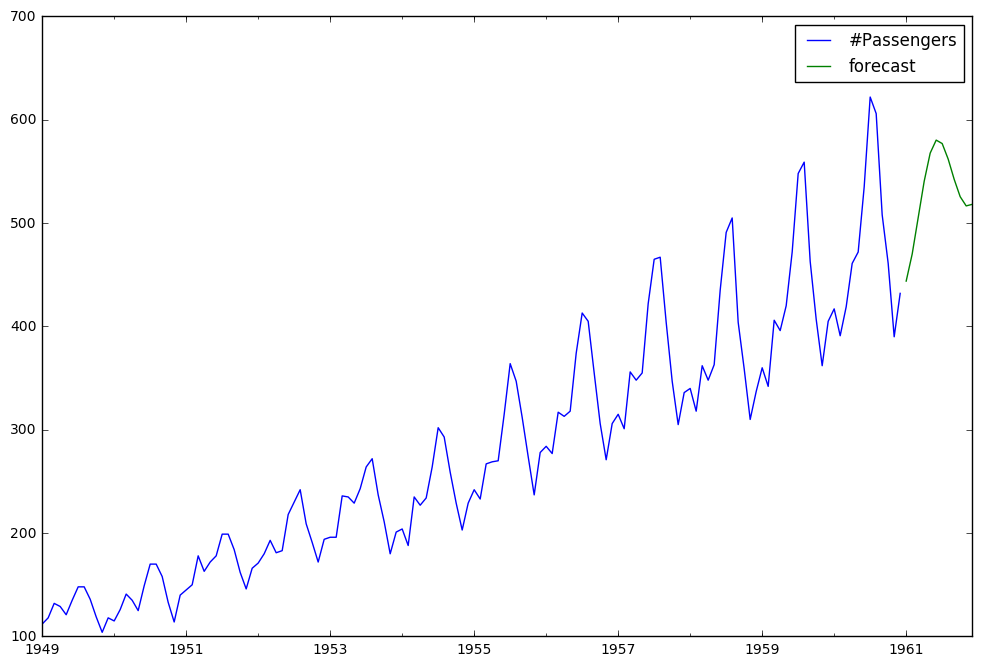

In [147]:
df.plot(figsize=(12,8))

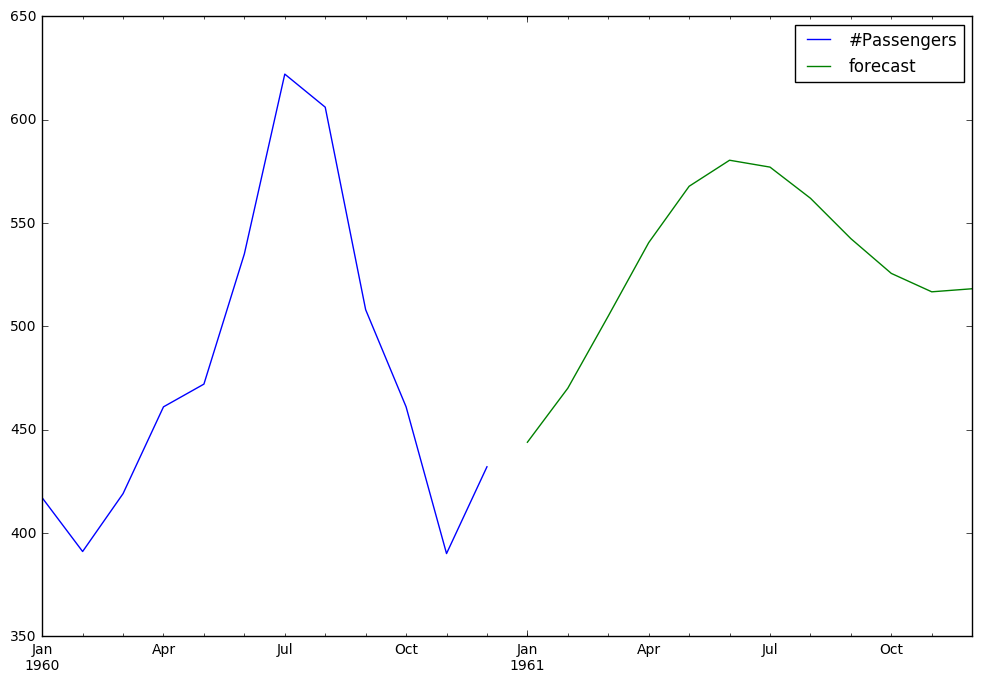

In [148]:
df[['#Passengers', 'forecast']].ix[-24:].plot(figsize=(12, 8)) 